In [1]:
import os
from datetime import date, datetime, timedelta
from contextlib import contextmanager
from collections import defaultdict

import psycopg2
import matplotlib.pyplot as plt

@contextmanager
def get_cursor():
    conn = psycopg2.connect(os.environ['DATABASE_URL'])
    cur = conn.cursor()
    
    try:
        yield cur
    finally:
        cur.close()
        conn.close()
        
def transpose(rows):
    values = tuple([[] for _ in range(len(rows[0]))])
    for row in rows:
        for idx, cell in enumerate(row):
            values[idx].append(cell)
            
    return values

def union_timeseries(*timeseries):
    unified_dict = defaultdict(lambda: [0 for _ in range(len(timeseries))])
    for tidx, ts in enumerate(timeseries):
        for date, value in ts:
            unified_dict[date][tidx] = value
        
    return sorted([(date, *values) for date, values in unified_dict.items()])

def top_n_plus_other(n, rows):
    s = sorted(rows, reverse=True)
    other_count = sum([r[0] for r in s[n:]])
    return s[:n] + [(other_count, 'Other')]


In [2]:
# Number of days into the past to run timeseries reports for
TIME_PERIOD = timedelta(days=21)
NOW = datetime.utcnow()

In [3]:
with get_cursor() as cur:
    cur.execute('SELECT COUNT(*) FROM "Post";')
    print('Total posts: %d' % cur.fetchone())

    cur.execute('SELECT COUNT(*) FROM "User";')
    print('Total users: %d' % cur.fetchone()) 

Total posts: 4186
Total users: 4830


* A user is "n-day productive" if they have made a post, post comment or thread comment within the last n days


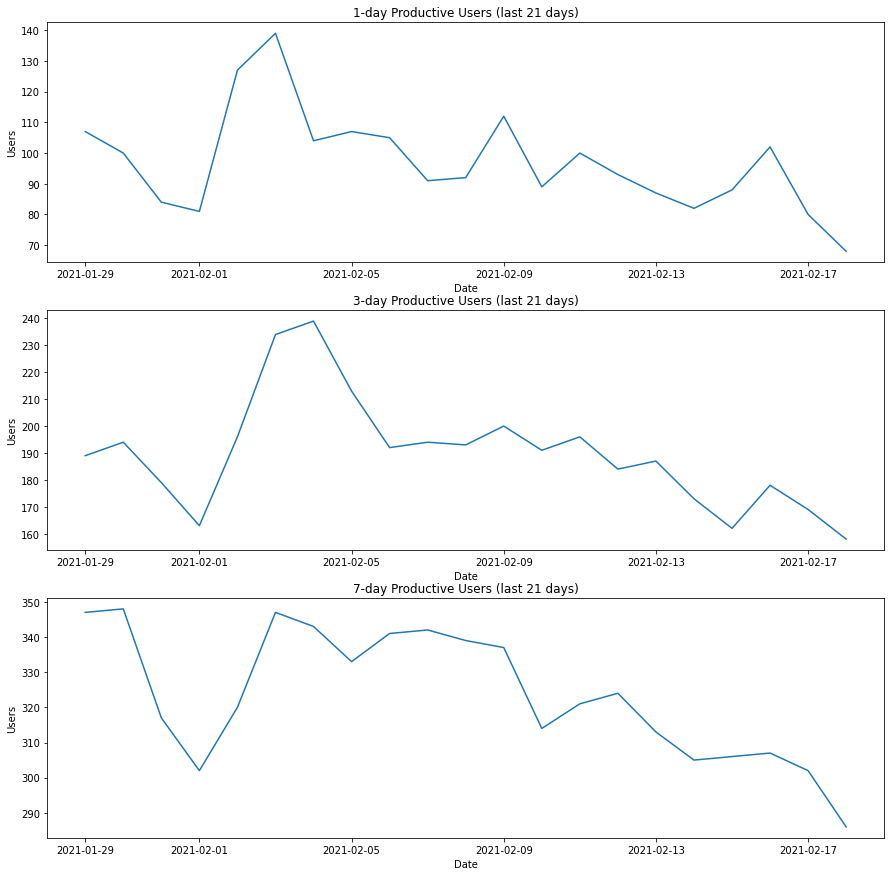

In [4]:
def n_day_productivity(cur, n, end):
    sample_end = end - timedelta(days=n)
    cur.execute('''
        SELECT sq1.user, sq1.when FROM (
            SELECT "authorId" as user, "createdAt"::Date as when FROM "Post" WHERE "Post"."createdAt" > %s UNION
            SELECT "authorId" as user, "createdAt"::Date as when FROM "PostComment" WHERE "PostComment"."createdAt" > %s UNION
            SELECT "authorId" as user, "createdAt"::Date as when FROM "Comment" WHERE "Comment"."createdAt" > %s
        ) as sq1
    ''', (sample_end, sample_end, sample_end))
    
    activesets = defaultdict(set)
    for uid, when in cur.fetchall():
        activesets[when].add(uid)
        
    days = [date.today() - timedelta(days=i) for i in range((datetime.utcnow() - end).days)]
    out = []
    for day in days:
        active_users_on_day = set()
        for i in range(n):
            active_users_on_day |= activesets[day - timedelta(days=i)]
            
        out.append((len(active_users_on_day), day))
        
    return out

with get_cursor() as cur:
    fig = plt.figure(figsize=(15,15))

    ## 1 day
    plt.subplot(3,1,1)
    user_counts, dates = transpose(n_day_productivity(cur, 1, NOW - TIME_PERIOD))
    
    plt.title('1-day Productive Users (last %d days)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Users')
    plt.plot(dates, user_counts)


    ## 3 day
    plt.subplot(3,1,2)
    user_counts, dates = transpose(n_day_productivity(cur, 3, NOW - TIME_PERIOD))

    plt.title('3-day Productive Users (last %d days)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Users')
    plt.plot(dates, user_counts)
    
    ## 7 day
    plt.subplot(3,1,3)
    user_counts, dates = transpose(n_day_productivity(cur, 7, NOW - TIME_PERIOD))

    plt.title('7-day Productive Users (last %d days)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Users')
    plt.plot(dates, user_counts)
    
    print('* A user is "n-day productive" if they have made a post, post comment '
          'or thread comment within the last n days')
    


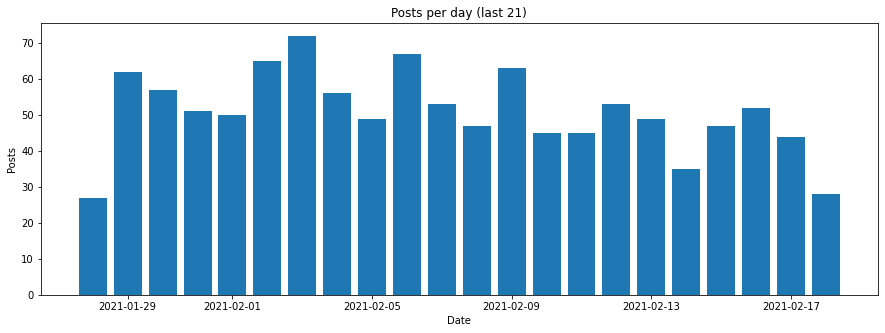

In [5]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "Post"
        WHERE "Post"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    rows = cur.fetchall()

    dates, post_counts = transpose(rows)

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    plt.title('Posts per day (last %d)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Posts')
    plt.bar(dates, post_counts)
    plt.show()


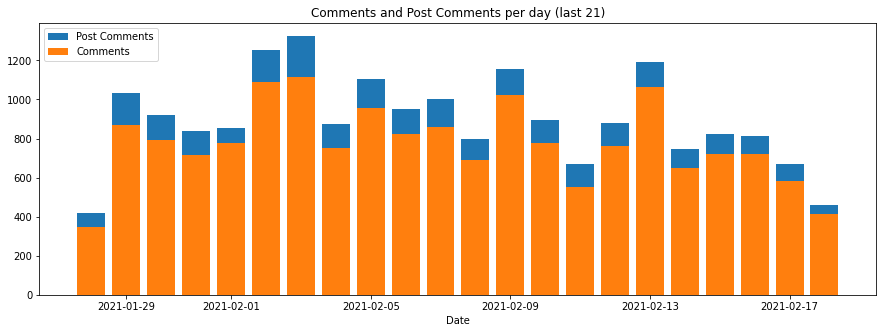

In [6]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "Comment"
        WHERE "Comment"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    comment_rows = cur.fetchall()
    
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "PostComment"
        WHERE "PostComment"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    post_comment_rows = cur.fetchall()

    dates, comment_counts, post_comment_counts = transpose(union_timeseries(comment_rows, post_comment_rows))

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    
    plt.bar(dates, post_comment_counts, bottom=comment_counts, label='Post Comments')
    plt.bar(dates, comment_counts, label='Comments')
    
    plt.title('Comments and Post Comments per day (last %d)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.legend(loc="upper left")
    
    plt.show()

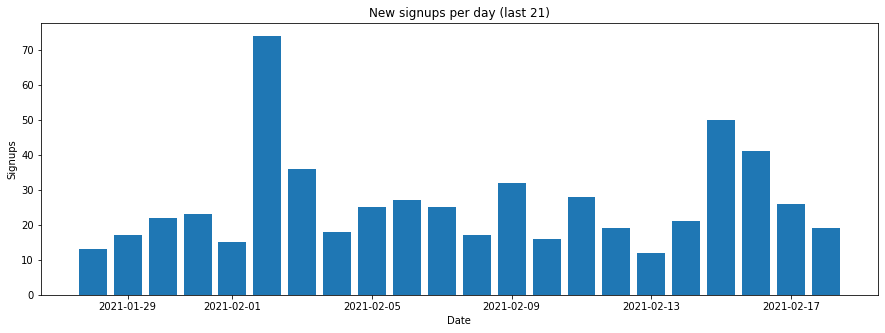

In [7]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "User"
        WHERE "User"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (NOW - TIME_PERIOD,))
    rows = cur.fetchall()

    dates, signup_counts = transpose(rows)

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    plt.title('New signups per day (last %d)' % TIME_PERIOD.days)
    plt.xlabel('Date')
    plt.ylabel('Signups')
    plt.bar(dates, signup_counts)
    plt.show()


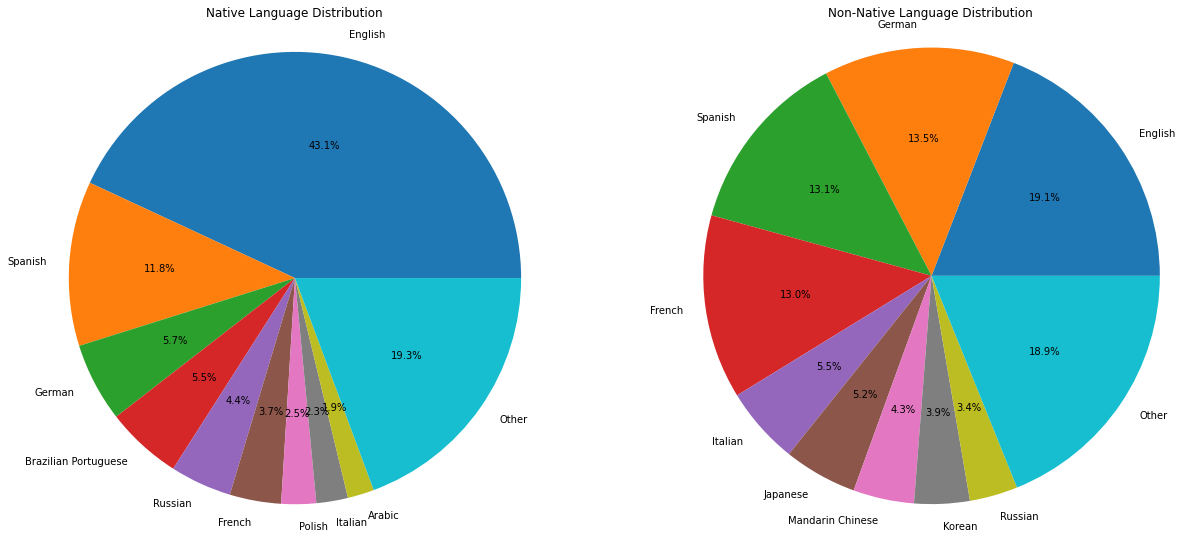

In [16]:
with get_cursor() as cur:
    cur.execute('''
        SELECT COUNT(*) as count, COALESCE(l."devName", l.name) FROM "LanguageRelation" as lr
        JOIN "Language" as l
        ON lr."languageId" = l.id
        WHERE lr.level = 'NATIVE'
        GROUP BY l.name, l."devName"
        ORDER BY count DESC;
    ''', (NOW - TIME_PERIOD,))
    ncounts, nlabels = transpose(top_n_plus_other(9, cur.fetchall()))
    
    cur.execute('''
        SELECT COUNT(*) as count, COALESCE(l."devName", l.name) FROM "LanguageRelation" as lr
        JOIN "Language" as l
        ON lr."languageId" = l.id
        WHERE lr.level != 'NATIVE'
        GROUP BY l.name, l."devName"
        ORDER BY count DESC;
    ''', (NOW - TIME_PERIOD,))
    lcounts, llabels = transpose(top_n_plus_other(9, cur.fetchall()))

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.subplots_adjust(0.3,0,3,1.75)
    
    ax1.title.set_text('Native Language Distribution')
    ax1.pie(ncounts, labels=nlabels, autopct='%1.1f%%')
    ax1.axis('equal')
    
    ax2.title.set_text('Non-Native Language Distribution')
    ax2.pie(lcounts, labels=llabels, autopct='%1.1f%%')
    ax2.axis('equal')

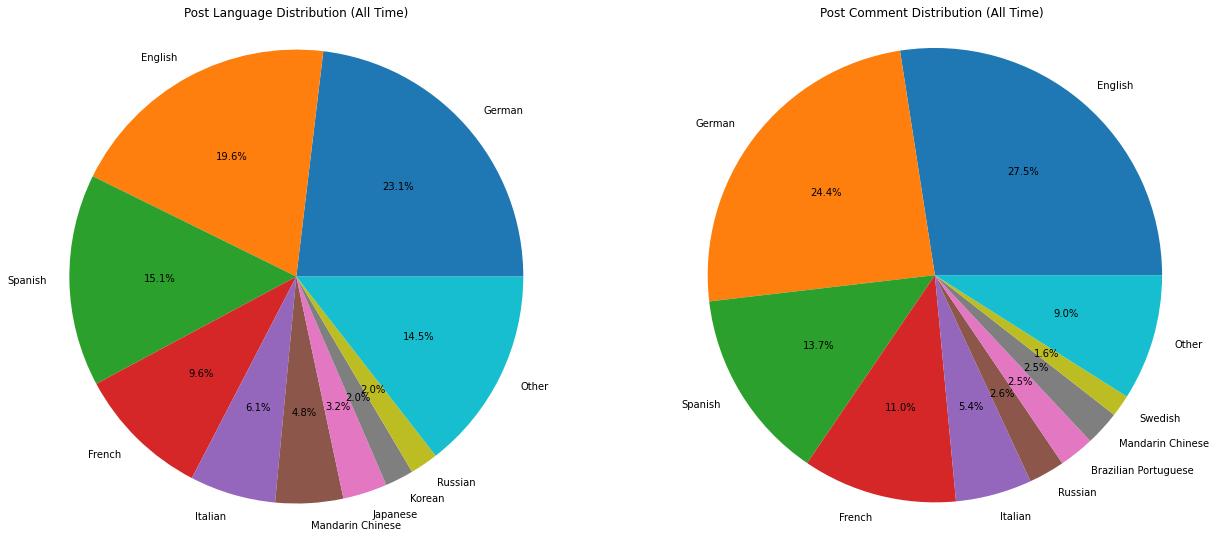

In [17]:
with get_cursor() as cur:
    cur.execute('''
        SELECT COUNT(*) as count, l.name, l."devName" FROM "Post" as p
        JOIN "Language" as l
        ON p."languageId" = l.id
        GROUP BY l.name, l."devName"
        ORDER BY count DESC;
    ''', (NOW - TIME_PERIOD,))
    plcounts, plnames, pldevnames = transpose(top_n_plus_other(9, cur.fetchall()))
    pllabels = [devName or name for devName, name in zip(pldevnames, plnames)] + ['Other']
    
    cur.execute('''
        SELECT COUNT(*) as count, l.name, l."devName" FROM "Comment" as c
        JOIN "Thread" as t ON c."threadId" = t.id
        JOIN "Post" as p ON t."postId" = p.id
        JOIN "Language" as l ON p."languageId" = l.id
        GROUP BY l.name, l."devName"
        ORDER BY count DESC;
    ''', (NOW - TIME_PERIOD,))
    pccounts, pcnames, pcdevnames= transpose(top_n_plus_other(9, cur.fetchall()))
    pclabels = [devName or name for devName, name in zip(pcdevnames, pcnames)] + ['Other']

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.subplots_adjust(0.3,0,3,1.75)
    
    ax1.title.set_text('Post Language Distribution (All Time)')
    ax1.pie(plcounts, labels=pllabels, autopct='%1.1f%%')
    ax1.axis('equal')
    
    ax2.title.set_text('Post Comment Distribution (All Time)')
    ax2.pie(pccounts, labels=pclabels, autopct='%1.1f%%')
    ax2.axis('equal')
    
    

In [18]:
print('All times/dates are UTC unless otherwise noted.')
print('Report generated %s' % NOW.isoformat())
print('Reporting Period: %s - %s' % (
    (NOW - TIME_PERIOD).isoformat('T', 'minutes'),
    NOW.isoformat('T', 'minutes')
))

All times/dates are UTC unless otherwise noted.
Report generated 2021-02-18T16:53:30.475901
Reporting Period: 2021-01-28T16:53 - 2021-02-18T16:53
